# imports

In [35]:
import numpy as np
import seaborn as sns
import pandas as pd
import json
from matplotlib import pyplot as plt
from model import *

In [36]:
AGENT_COUNT = 248
EXPERIMENT_STEPS = 200_000
PERFORM_RUN = False

Set up a baseline

Run the 4-link model and then the 5-link model to show that travel times increase for all routes.

In [37]:
def save_results(dataframe: pd.DataFrame, filename: str):
    dataframe.to_csv(filename)


def load_results(filename: str) -> pd.DataFrame:
    return pd.read_csv(filename, index_col=0)


def get_agent_histories(agents) -> list:
    return [agent.history for agent in agents]


def save_agent_histories(agents, filename: str):
    histories = get_agent_histories(agents)
    with open(filename, "w") as f:
        json.dump(histories, f)


def load_agent_histories(filename: str):
    with open(filename, "r") as f:
        return json.load(f)


def save_model(model, model_name: str):
    model_results = model.datacollector.get_model_vars_dataframe()
    model_agents = model.schedule.agents
    save_results(model_results, f"{model_name}_results.csv")
    save_agent_histories(model_agents, f"{model_name}_histories.json")


def load_model(model_name: str):
    return load_results(f"{model_name}_results.csv"), load_agent_histories(f"{model_name}_histories.json")

In [38]:
if PERFORM_RUN:
    model_4link = Model_4link(AGENT_COUNT)
    model_4link.initialize_agents_positions()

    model_5link = Model_5link(AGENT_COUNT)
    model_5link.initialize_agents_positions()

    for _ in range(EXPERIMENT_STEPS):
        model_4link.step()
        model_5link.step()

    save_model(model_4link, "model_4link")
    save_model(model_5link, "model_5link")

In [39]:
model_4link_results, model_4link_histories = load_model("model_4link")
model_5link_results, model_5link_histories = load_model("model_5link")

# Data analysis and visualization

In [123]:
def plot_travel_times(dataframe: pd.DataFrame, model_name: str):
    travel_times = None
    if dataframe.shape[1] == 4:
        # 4-link model
        travel_times = dataframe.iloc[:, 0:2]
    elif dataframe.shape[1] == 6:
        # 5-link model
        travel_times = dataframe.iloc[:, 0:3]
    elif dataframe.shape[1] == 7:
        # 5-link model with toll
        travel_times = dataframe.iloc[:, 0:4]
        raise NotImplementedError("toll not implemented")
    else:
        raise ValueError("dataframe must have 4 to 6 columns")
    
    travel_times = travel_times.rolling(1000).mean()
    travel_times = travel_times[::1000]
    
    avg_travel_times = travel_times.mean(axis=1)
    travel_times["avg travel time"] = avg_travel_times
    
    g = sns.lineplot(data=travel_times)
    g.set(title="", ylabel="travel time", xlabel="ticks")
    g.set(ylim=(0, 1000))

    plt.savefig(f"{model_name}_travel_times.svg", format="svg")

/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarni

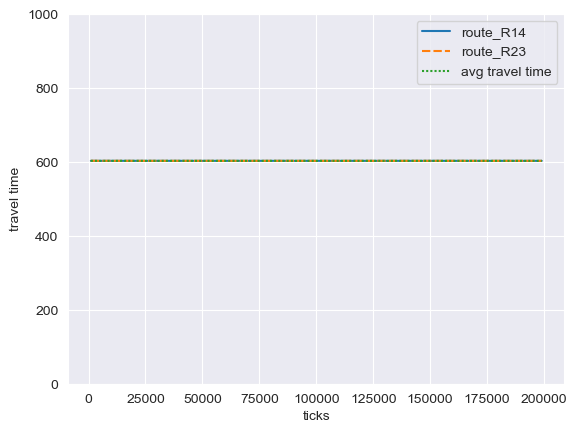

In [124]:
plot_travel_times(model_4link_results, "model_4link")

/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarni

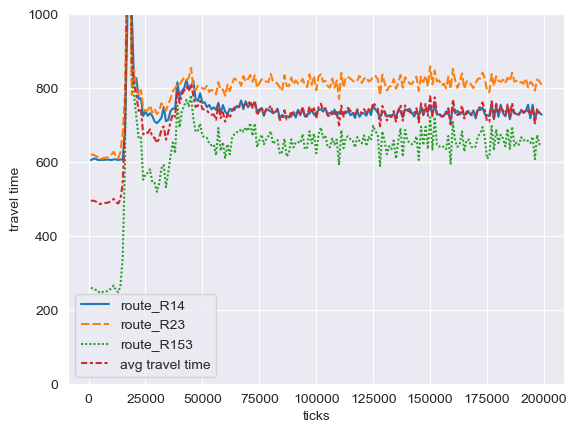

In [125]:
plot_travel_times(model_5link_results, "model_5link")

## Find the final average travel times per route, as remembered by the agents
(for each agent, check their 30 round history, save the average travel time per route)

In [43]:
def final_average_travel_times(histories):
    # assert one history per agent
    assert len(histories) == 248
    # assert each agent has a history of 30 steps
    for history in histories:
        assert len(history) == 30

    travel_times = {}
    for history in histories:
        for step in history:
            # step: [route, travel_time]
            if step[0] not in travel_times.keys():
                travel_times[step[0]] = []
            travel_times[step[0]].append(step[1])
    print("Total occurrences: ", {route: len(v) for route, v in travel_times.items()})
    print("Averages: ", {route: round(np.mean(v)) for route, v in travel_times.items()})

    return {route: round(np.mean(v)) for route, v in travel_times.items()}

In [44]:
final_average_travel_times(model_4link_histories)

Total occurrences:  {'R23': 3476, 'R14': 3964}
Averages:  {'R23': 603, 'R14': 603}


{'R23': 603, 'R14': 603}

In [45]:
final_average_travel_times(model_5link_histories)

Total occurrences:  {'R153': 5226, 'R14': 1871, 'R23': 343}
Averages:  {'R153': 658, 'R14': 736, 'R23': 818}


{'R153': 658, 'R14': 736, 'R23': 818}

From these averages can be seen that for the 5-link system, everyone is worse off. Thus, in this case, adding the road gives rise to Braess paradox

In [46]:
def find_agent_strategy(histories):
    agent_strategies = {}
    for history in histories:
        agent_strategy = []
        for step in history:
            if step[0] not in agent_strategy:
                agent_strategy.append(step[0])
        agent_strategy = tuple(sorted(agent_strategy))
        if agent_strategy not in agent_strategies.keys():
            agent_strategies[agent_strategy] = 0
        agent_strategies[agent_strategy] += 1

    return agent_strategies


def interpret_agent_strategies(histories):
    print("we found that")
    for strat, count in find_agent_strategy(histories).items():
        print(f" - {count} agents took route {' and '.join(strat)}")
    print("in their last 30 passes through the network")

In [47]:
interpret_agent_strategies(model_4link_histories)

we found that
 - 197 agents took route R14 and R23
 - 23 agents took route R23
 - 28 agents took route R14
in their last 30 passes through the network


In [48]:
interpret_agent_strategies(model_5link_histories)

we found that
 - 181 agents took route R14 and R153 and R23
 - 65 agents took route R14 and R153
 - 2 agents took route R153 and R23
in their last 30 passes through the network


# Plot the throughput of each route during training
throughput is plotted as the average number of cars that pass through a route per 1000 ticks, averaged over 3000 ticks 

In [120]:

def plot_throughput(dataframe: pd.DataFrame, model_name: str):
    """
    Plot the average throughput of the network per 1000 ticks
    """
    throughput: pd.DataFrame | None = None
    if dataframe.shape[1] == 4:
        # 4-link model
        throughput = dataframe.iloc[:, 2:4]
    elif dataframe.shape[1] == 6:
        # 5-link model
        throughput = dataframe.iloc[:, 3:6]
    elif dataframe.shape[1] == 7:
        # 5-link model with toll
        throughput = dataframe.iloc[:, 4:7]
        raise NotImplementedError("toll not implemented")
    else:
        raise ValueError("dataframe must have 4 to 6 columns")
    
    # data is stored cumulatively, so use diff() to get the increments 
    # (in our case 0 or 1 because of TASEP only letting one car through at a time)
    throughput = throughput.diff()
    
    # get total throughput per route per 1000 ticks
    # got this from https://stackoverflow.com/questions/47239332/take-the-sum-of-every-n-rows-in-a-pandas-series
    throughput = throughput.groupby(throughput.index // 1000).sum()    
    
    # get average throughput per route per 1000 ticks, over 3000 ticks
    throughput = throughput.rolling(3).mean()
    
    # get total throughput of the network (all routes)
    throughput["total throughput"] = throughput.sum(axis=1)
    
    # drop the last row, as this is not a full 1000 ticks
    throughput = throughput[:-1]
    
    # drop the first 2 rows, as these are NaN because of the rolling mean
    throughput = throughput[2:]

    g = sns.lineplot(data=throughput)
    g.set(title="", ylabel="throughput", xlabel="1000 ticks")
    g.set(ylim=(0, 550))

    plt.savefig(f"{model_name}_throughput.svg", format="svg")

/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarni

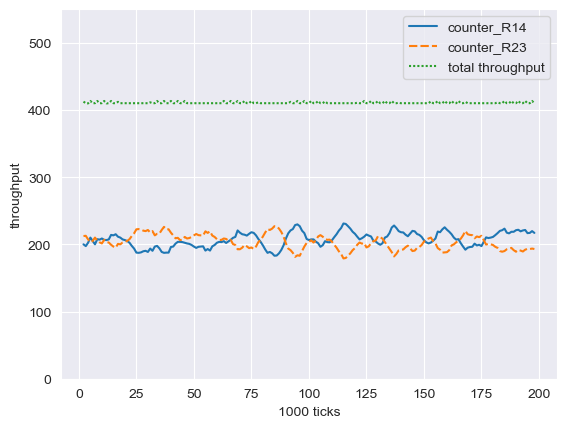

In [121]:
plot_throughput(model_4link_results, "model_4link")

/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/Caskroom/miniconda/base/envs/dmas_braess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarni

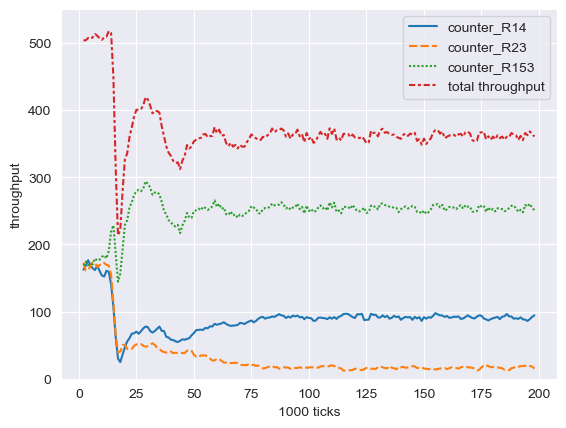

In [122]:
plot_throughput(model_5link_results, "model_5link")